<a href="https://colab.research.google.com/github/arti163/nowe_repo/blob/master/SatteliteImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.2 MB/s eta 0:00:00


In [2]:
# 1. Imports

# 1.a Importing standard libraries for file operations and random number generation
import os  # For interacting with the operating system
import time  # For measuring time and performance
import shutil  # For file and directory operations
import random  # For generating random numbers

# 1.b Importing numerical and visualization libraries
import numpy as np  # For numerical operations and array manipulation
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For plotting and visualizations

# 1.c Importing PyTorch libraries for deep learning
import torch  # Core PyTorch library
import torchvision  # For datasets and pretrained models
import torchvision.transforms as transforms  # For data augmentation and transformations
from torchvision.datasets import ImageFolder  # For loading image datasets organized in folders

# 1.d Importing PyTorch modules for building and training neural networks
import torch.nn as nn  # For defining neural network layers
import torch.nn.functional as F  # For activation functions and other utilities
import torch.optim as optim  # For optimization algorithms

# 1.e Additional tools for progress visualization and evaluation
from tqdm import tqdm  # For creating progress bars
import sklearn  # For machine learning utilities
from sklearn.metrics import confusion_matrix  # For calculating the confusion matrix

In [3]:
%reload_ext watermark
%watermark -a "Artur Pawelek"

Author: Artur Pawelek



In [4]:
# 2. Check the GPU model

# 2.a Verify if a GPU is available
if torch.cuda.is_available():
    # 2.a.1 Print the number of GPUs available
    print('Number of GPUs:', torch.cuda.device_count())

    # 2.a.2 Print the model name of the first GPU
    print('GPU Model:', torch.cuda.get_device_name(0))

    # 2.a.3 Print the total GPU memory in GB
    print('Total GPU Memory [GB]:', torch.cuda.get_device_properties(0).total_memory / 1e9)

Number of GPUs: 1
GPU Model: Tesla T4
Total GPU Memory [GB]: 15.835660288


In [5]:
# 3. Reset GPU memory

# 3.a Import the required library for GPU memory management
from numba import cuda  # Provides tools to interact with NVIDIA GPUs

# 3.b Get the current GPU device
device = cuda.get_current_device()  # Retrieves the current active GPU device

# 3.c Reset the GPU memory
device.reset()  # Clears the GPU memory to free up resources

Organizing Images on Disk

In [6]:
# 4. Delete folders (if they exist)

# 4.a Attempt to remove specified folders
try:
    shutil.rmtree('EuroSAT_RGB')  # Deletes the EuroSAT_RGB folder
    shutil.rmtree('__MACOSX')  # Deletes the __MACOSX folder
    shutil.rmtree('training_images')  # Deletes the training images folder
    shutil.rmtree('testing_images')  # Deletes the testing images folder

# 4.b Handle exceptions if folders do not exist or cannot be deleted
except Exception as e:
    print(f"The folders do not exist or have already been deleted!")  # Prints an error message

The folders do not exist or have already been deleted!


In [7]:
# 5. Use only the first time you run the project

# 5.a Extract the EuroSAT_RGB.zip file
!unzip EuroSAT_RGB.zip  # Unzips the file into the current directory

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2494.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2494.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2480.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2480.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_292.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_292.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1189.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1189.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1837.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1837.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2496.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2496.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_284.jpg  
  inflating: __MACOSX/EuroSAT_RGB/Perman

In [8]:
# 6. Create folders

# 6.a Create a folder for training images
os.mkdir('training_images')  # Creates the 'training_images' directory

# 6.b Create a folder for testing images
os.mkdir('testing_images')  # Creates the 'testing_images' directory

In [9]:
# 7. Define the source directory

# 7.a Set the source folder for the images
images_source = 'EuroSAT_RGB'  # Specifies the folder containing the source images

In [10]:
# 8. Define the destination directories

# 8.a Set the destination folder for training images
training_destination = 'training_images'  # Specifies the folder for training images

# 8.b Set the destination folder for testing images
testing_destination = 'testing_images'  # Specifies the folder for testing images

Automating Image Separation

In [11]:
# 9. Class variable and dictionary

# 9.a Initialize the class variable
image_class = 0  # Used to assign a class ID to each category of images

# 9.b Initialize the class dictionary
class_dict = {}  # Stores the mapping of class IDs to class names

In [12]:
# 10. Create a variable to manage the files

# 10.a List all files in the source directory
files = os.listdir(images_source)  # Retrieves the list of files in the source folder

# 10.b Sort the files alphabetically
files.sort()  # Ensures the files are processed in a consistent order

In [13]:
files

['.DS_Store',
 'AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [14]:
# 11. Iterate over all files (or directories) in the 'files' list
for file_path in files:

    # 11.a Check if the file (or directory) name does not start with a dot (not hidden)
    if file_path[0] != '.':

        # 11.b List all images in the specified directory
        images = os.listdir(images_source + '/' + file_path)

        # 11.c Calculate the sample size for the training set (80% of total images)
        sample_size = int(len(images) * 0.8)

        # 11.d Initialize an empty list to store the names of training images
        train = []

        # 11.e Define the final destination for the training images
        final_dest = training_destination + '/' + str(image_class)

        # 11.f Create a new directory for the training images
        os.mkdir(final_dest)

        # 11.g Select a random sample of images for the training set and copy them to the final destination
        for file_name in random.sample(images, sample_size):

            # 11.g.1 Copy the image to the destination directory
            shutil.copy2(os.path.join(images_source, file_path, file_name), final_dest)

            # 11.g.2 Add the image name to the training list
            train.append(file_name)

        # 11.h Get the list of images not selected for training (testing images)
        test_images = list(set(images) - set(train))

        # 11.i Define the final destination for the testing images
        final_dest = testing_destination + '/' + str(image_class)

        # 11.j Create a new directory for the testing images
        os.mkdir(final_dest)

        # 11.k Copy all testing images to the destination directory
        for test_image in test_images:
            shutil.copy2(os.path.join(images_source, file_path, test_image), final_dest)

        # 11.l Map the image class to its corresponding file path in the 'class_dict' dictionary
        class_dict[image_class] = file_path

        # 11.m Increment the image class identifier
        image_class += 1

Preprocessing and Creation of Dataloaders

In [15]:
# 12. Data transformations

# 12.a Define a sequence of transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes the image with mean and standard deviation
])

In [16]:
# 13. Training dataset

# 13.a Create the training dataset
training_dataset = torchvision.datasets.ImageFolder(
    root='training_images',  # Path to the training images directory
    transform=transform  # Apply the defined transformations
)

In [17]:
# 14. Training dataloader

# 14.a Create the training dataloader
training_dataloader = torch.utils.data.DataLoader(
    training_dataset,  # Use the training dataset
    batch_size=64,  # Define the batch size
    shuffle=True,  # Shuffle the data at every epoch
    num_workers=2  # Use two subprocesses for data loading
)

In [18]:
# 15. Testing dataset

# 15.a Create the testing dataset
testing_dataset = torchvision.datasets.ImageFolder(
    root='testing_images',  # Path to the testing images directory
    transform=transform  # Apply the defined transformations
)

In [19]:
# 16. Testing dataloader

# 16.a Create the testing dataloader
testing_dataloader = torch.utils.data.DataLoader(
    testing_dataset,  # Use the testing dataset
    batch_size=1,  # Define the batch size
    shuffle=True,  # Shuffle the data at every epoch
    num_workers=2  # Use two subprocesses for data loading
)

Visualizing Images

In [20]:
# 17. Function to visualize images

def imshow(img):
    # 17.a Normalize the image
    img = img / 2 + 0.5  # Reverse the normalization applied earlier

    # 17.b Convert the image to a numpy array
    npimg = img.numpy()

    # 17.c Display the image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Rearrange dimensions for visualization
    plt.show()

In [21]:
# 18. Obtain a batch of images

# 18.a Create an iterator for the training dataloader
data_iter = iter(training_dataloader)

# 18.b Get the next batch of images and labels
images, labels = next(data_iter)

In [22]:
# 19. Class mapping

# 19.a Define a dictionary to map class indices to their respective labels
class_mapping = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

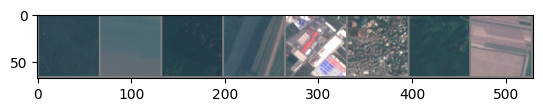

Labels: 1 9 1 8 4 7 1 0


In [23]:
# 20. Display the images

# 20.a Display a grid of the first 8 images from the batch
imshow(torchvision.utils.make_grid(images[:8]))  # Creates a grid of images and displays them

# 20.b Print the labels of the displayed images
print('Labels:', ' '.join('%d' % labels[j] for j in range(8)))  # Shows the labels for the first 8 images

Modeling - Building the Deep Learning Model

In [24]:
# 21. Define a new model class called CustomNet, inheriting from nn.Module
class CustomNet(nn.Module):

    # 21.a Constructor method of the class
    def __init__(self):

        # 21.a.1 Call the constructor of the parent class (nn.Module)
        super(CustomNet, self).__init__()

        # 21.a.2 Define the first convolutional layer with 3 input channels, 64 output channels,
        # and a 3x3 kernel
        self.conv1 = nn.Conv2d(3, 64, 3, 1)

        # 21.a.3 Define the second convolutional layer with 64 input channels, 128 output channels,
        # and a 3x3 kernel
        self.conv2 = nn.Conv2d(64, 128, 3, 1)

        # 21.a.4 Define the third convolutional layer with 128 input channels, 256 output channels,
        # and a 3x3 kernel
        self.conv3 = nn.Conv2d(128, 256, 3, 1)

        # 21.a.5 Define the first dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)

        # 21.a.6 Define the second dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)

        # 21.a.7 Define the first fully connected (Dense) layer mapping from 215296 to 2048 neurons
        self.fc1 = nn.Linear(215296, 2048)

        # 21.a.8 Define the second fully connected layer mapping from 2048 to 512 neurons
        self.fc2 = nn.Linear(2048, 512)

        # 21.a.9 Define the third fully connected layer mapping from 512 to 128 neurons
        self.fc3 = nn.Linear(512, 128)

        # 21.a.10 Define the fourth fully connected layer mapping from 128 to 10 neurons
        self.fc4 = nn.Linear(128, 10)

    # 21.b Define the forward method for the forward pass
    def forward(self, x):

        # 21.b.1 Apply the first convolutional layer
        x = self.conv1(x)

        # 21.b.2 Apply the ReLU activation function
        x = F.relu(x)

        # 21.b.3 Apply the second convolutional layer
        x = self.conv2(x)

        # 21.b.4 Apply the ReLU activation function
        x = F.relu(x)

        # 21.b.5 Apply the third convolutional layer
        x = self.conv3(x)

        # 21.b.6 Apply the ReLU activation function
        x = F.relu(x)

        # 21.b.7 Apply max pooling with a 2x2 kernel
        x = F.max_pool2d(x, 2)

        # 21.b.8 Apply the first dropout layer
        x = self.dropout1(x)

        # 21.b.9 Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # 21.b.10 Apply the first fully connected layer
        x = self.fc1(x)

        # 21.b.11 Apply the ReLU activation function
        x = F.relu(x)

        # 21.b.12 Apply the second dropout layer
        x = self.dropout2(x)

        # 21.b.13 Apply the second fully connected layer
        x = self.fc2(x)

        # 21.b.14 Apply the ReLU activation function
        x = F.relu(x)

        # 21.b.15 Apply the third fully connected layer
        x = self.fc3(x)

        # 21.b.16 Apply the ReLU activation function
        x = F.relu(x)

        # 21.b.17 Apply the fourth fully connected layer
        x = self.fc4(x)

        # 21.b.18 Return the softmax output along dimension 1 (commonly used for classification)
        return F.log_softmax(x, dim=1)


In [25]:
# 22. Create the model

# 22.a Instantiate the model using the CustomNet class
model = CustomNet()  # Initializes the deep learning model

In [26]:
# 22.b Print the model architecture

print(model)

CustomNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
# 23. Define the device

# 23.a Check if a GPU is available; otherwise, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 23.b Print the selected device
print(device)

cuda:0


In [28]:
# 23.c Send the model to the selected device
model.to(device)  # Moves the model to GPU if available; otherwise, keeps it on CPU

CustomNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

Selecting the Loss Function

In [29]:
# 24. Loss function

# 24.a Define the loss function as Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

Selecting the Optimizer

In [30]:
# 25. Optimizer

# 25.a Define the optimizer as Adam
optimizer = optim.Adam(model.parameters())  # Optimizer to adjust the model's weights

Model Training

In [31]:
# 26. Number of epochs

# 26.a Define the number of training epochs
num_epochs = 30  # Total number of iterations over the entire dataset

In [32]:
# 27. Test iteration

# 27.a Create an iterator for the testing dataloader
test_iter = iter(testing_dataloader)  # Initializes an iterator to sample data from the testing set

In [33]:
%%time
print('Training Started!')

# 28. Iterate through the number of epochs
for epoch in range(num_epochs):

    # 28.a Initialize the variable to accumulate loss over the epoch
    running_loss = 0.0

    # 28.b Initialize a counter for the batches
    i = 0

    # 28.c Iterate over the training data with a progress bar (tqdm)
    for data in (pbar := tqdm(training_dataloader)):

        # 28.c.1 Update the progress bar description to show the current epoch
        pbar.set_description(f"\nEpoch {epoch}")

        # 28.c.2 Unpack the batch data into inputs and labels
        inputs, labels = data

        # 28.c.3 Move inputs and labels to the appropriate device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 28.c.4 Zero the gradients of the optimizer
        optimizer.zero_grad()

        # 28.c.5 Perform the forward pass through the neural network
        outputs = model(inputs)

        # 28.c.6 Calculate the loss using the defined criterion
        loss = criterion(outputs, labels)

        # 28.c.7 Perform the backward pass to calculate gradients
        loss.backward()

        # 28.c.8 Update the neural network weights using the optimizer
        optimizer.step()

        # 28.c.9 Update the accumulated loss value
        running_loss += loss.item()

        # 28.c.10 Initialize counters for the number of correct predictions and total samples
        total_correct = 0
        total_samples = 0

        # 28.c.11 Perform validation every 100 batches
        if i % 100 == 0:

            # 28.c.11.a Disable gradient computation to save memory and processing time
            with torch.no_grad():

                # 28.c.11.b Get a batch of test images and labels
                test_images, test_labels = next(test_iter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                # 28.c.11.c Perform a forward pass on the neural network with 8 test images
                test_outputs = model(test_images[:8])

                # 28.c.11.d Get predictions for the 8 test images
                _, predicted = torch.max(test_outputs, 1)

        # 28.c.12 Increment the batch counter
        i += 1

    # 28.d Display the average loss for the epoch
    print(f"Epoch {epoch}, Loss: {running_loss / (i)}")

print('Training Completed!')

Training Started!


Epoch 0: 100%|██████████| 338/338 [01:34<00:00,  3.57it/s]


Epoch 0, Loss: 1.142748063485298


Epoch 1: 100%|██████████| 338/338 [01:34<00:00,  3.58it/s]


Epoch 1, Loss: 0.6649531723832237


Epoch 2: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 2, Loss: 0.4880103402324682


Epoch 3: 100%|██████████| 338/338 [01:34<00:00,  3.57it/s]


Epoch 3, Loss: 0.34297289430389744


Epoch 4: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 4, Loss: 0.23951451046138825


Epoch 5: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 5, Loss: 0.1523149995816618


Epoch 6: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 6, Loss: 0.12948317632365686


Epoch 7: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 7, Loss: 0.1125831842510658


Epoch 8: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


Epoch 8, Loss: 0.09028850009075239


Epoch 9: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 9, Loss: 0.0812669954443152


Epoch 10: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


Epoch 10, Loss: 0.07001107139512897


Epoch 11: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 11, Loss: 0.052434963717665414


Epoch 12: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 12, Loss: 0.05925623789624609


Epoch 13: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 13, Loss: 0.06261659978362649


Epoch 14: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 14, Loss: 0.0612301937708791


Epoch 15: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 15, Loss: 0.04005649721963929


Epoch 16: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 16, Loss: 0.04832127329171584


Epoch 17: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


Epoch 17, Loss: 0.04956026900695367


Epoch 18: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 18, Loss: 0.03352430505926818


Epoch 19: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 19, Loss: 0.04268212364170254


Epoch 20: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


Epoch 20, Loss: 0.049563976226787126


Epoch 21: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 21, Loss: 0.035367415816152534


Epoch 22: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


Epoch 22, Loss: 0.0372488843273222


Epoch 23: 100%|██████████| 338/338 [01:35<00:00,  3.56it/s]


Epoch 23, Loss: 0.039889778233841565


Epoch 24: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 24, Loss: 0.03458743460421118


Epoch 25: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


Epoch 25, Loss: 0.027582067906611007


Epoch 26: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


Epoch 26, Loss: 0.048060848139131376


Epoch 27: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 27, Loss: 0.04789181785512612


Epoch 28: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch 28, Loss: 0.02955519940094735


Epoch 29: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]

Epoch 29, Loss: 0.041758470770186705
Training Completed!
CPU times: user 41min 54s, sys: 29.7 s, total: 42min 23s
Wall time: 47min 36s


Model Evaluation

In [34]:
# 29. Initialize counters

# 29.a Counter for the number of correct predictions
total_correct = 0  # Tracks the total number of correct classifications

# 29.b Counter for the total number of samples
total_samples = 0  # Tracks the total number of samples evaluated

In [35]:
# 30. Evaluate the model

# 30.a Set the model to evaluation mode (disables layers like dropout and batch normalization)
model.eval()

# 30.b Disable gradient calculation to save memory and processing time
with torch.no_grad():

    # 30.c Iterate over the testing data with a progress bar (tqdm)
    for data in (pbar := tqdm(testing_dataloader)):

        # 30.c.1 Update the progress bar description to show "Evaluating Model"
        pbar.set_description(f"Evaluating the Model.")

        # 30.c.2 Unpack the batch data into inputs and labels
        inputs, labels = data

        # 30.c.3 Move inputs and labels to the appropriate device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 30.c.4 Perform the forward pass through the model
        outputs = model(inputs)

        # 30.c.5 Get the predicted class (index of the maximum value) for each input in the batch
        _, predicted = torch.max(outputs.data, 1)

        # 30.c.6 Increment the total number of samples by the batch size
        total_samples += labels.size(0)

        # 30.c.7 Increment the total number of correct predictions for the current batch
        total_correct += (predicted == labels).sum().item()

Evaluating the Model.: 100%|██████████| 5400/5400 [01:07<00:00, 79.87it/s]


In [36]:
# 31. Calculate accuracy

# 31.a Compute the accuracy as the ratio of correct predictions to total samples
accuracy = total_correct / total_samples

# 31.b Print the calculated accuracy
print(accuracy)  # Displays the overall accuracy of the model

0.8362962962962963


Model Deployment and Usage

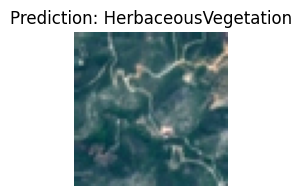

In [48]:
# 32. Evaluate and use the model for prediction

# 32.a Set the model to evaluation mode
with torch.no_grad():

    # 32.a.1 Get the first batch of data
    data_iter = iter(testing_dataloader)
    data = next(data_iter)

    # 32.a.2 Extract the inputs (images) from the batch
    inputs, _ = data

    # 32.a.3 Select the first image from the batch
    image = inputs[0].unsqueeze(0)

    # 32.a.4 Move the image to the same device as the model
    image = image.to(device)

    # 32.a.5 Perform inference to get the model's prediction for the image
    outputs = model(image)

    # 32.a.6 Get the index of the predicted class
    _, predicted = torch.max(outputs, 1)

    # 32.a.7 Convert the image to a NumPy array for visualization
    image_numpy = image.cpu().numpy()[0]  # Move the image back to CPU and convert to NumPy

    # 32.a.8 Rearrange dimensions from [C, H, W] to [H, W, C] for visualization
    image_numpy = np.transpose(image_numpy, (1, 2, 0))

    # 32.a.9 Adjust image channels if necessary
    if image_numpy.shape[2] == 1:  # Grayscale images
        image_numpy = np.squeeze(image_numpy, axis=2)
    elif image_numpy.shape[2] == 3:  # RGB images
        # Normalize to the range [0, 1] for proper visualization
        image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())

    # 32.a.10 Display the image with its predicted label
    plt.figure(figsize=(2, 2))
    plt.imshow(image_numpy)
    plt.title(f'Prediction: {class_mapping[predicted.item()]}')
    plt.axis('off')
    plt.show()

In [38]:
%watermark -a "Artur Pawelek"

Author: Artur Pawelek



In [39]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [40]:
%watermark --iversions

numba      : 0.60.0
sklearn    : 1.6.0
matplotlib : 3.10.0
numpy      : 1.26.4
seaborn    : 0.13.2
torchvision: 0.20.1+cu121
tqdm       : 4.67.1
torch      : 2.5.1+cu121

